## Data Analysis
This section assesses the input data quality and generic dimensions. It also concludes the basic analysis of which entities are considered to be used for the modeling in the later stages.

The dataset contains the main features of a real-world scenario:
- high inbalance
- time series
- multiple sensors and transparent readings (sensor modules of a generic ecosystem)

The dataset:
https://www.kaggle.com/datasets/nphantawee/pump-sensor-data?resource=download

Through the analysis, the following key aspects were discovered:
- The dataset is highly inbalanced and the pure error terms are 0.000034% of the entire dataset
- Due to the nature of time-series data, the oppotunities of oversampling, undersampling are very limited

### Conclusion:
- Incorporating the "Recovery" status of the dataset as error term will improve the inbalance to 0.07% representation
- Testing time series transformations (i.e.: rolling windows) might improve the performance
- Test the performance on the standard modelling tools and also try anomaly detection procedures

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.data_transformations import normalizer
from src.visualisations import time_series_error_by_sensor
from data.get_data import 

### Import the raw dataaset
For the analysis, we use the pump_data set from Kaggle:
https://www.kaggle.com/datasets/nphantawee/pump-sensor-data?resource=download

In [2]:
df = pd.read_csv("data/raw/sensor.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

In [4]:
df.describe()

,Unnamed: 0,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,220320.000000,210112.000000,219951.000000,220301.000000,220301.000000,220301.000000,220301.000000,215522.000000,214869.000000,215213.000000,...,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,143303.000000,204937.000000
mean,110159.500000,2.372221,47.591611,50.867392,43.752481,590.673936,73.396414,13.501537,15.843152,15.200721,...,35.453455,43.879591,42.656877,43.094984,48.018585,44.340903,150.889044,57.119968,183.049260,202.699667
std,63601.049991,0.412227,3.296666,3.666820,2.418887,144.023912,17.298247,2.163736,2.201155,2.037390,...,10.259521,11.044404,11.576355,12.837520,15.641284,10.442437,82.244957,19.143598,65.258650,109.588607
min,0.000000,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,0.028935,...,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779
25%,55079.750000,2.438831,46.310760,50.390620,42.838539,626.620400,69.976260,13.346350,15.907120,15.183740,...,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,167.534700,179.108800
50%,110159.500000,2.456539,48.133678,51.649300,44.227428,632.638916,75.576790,13.642940,16.167530,15.494790,...,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,193.865700,197.338000
75%,165239.250000,2.499826,49.479160,52.777770,45.312500,637.615723,80.912150,14.539930,16.427950,15.697340,...,36.979164,46.614580,45.138890,44.849540,51.215280,46.585650,208.333300,60.763890,219.907400,216.724500
max,220319.000000,2.549016,56.727430,56.032990,48.220490,800.000000,99.999880,22.251160,23.596640,24.348960,...,374.218800,408.593700,1000.000000,320.312500,370.370400,303.530100,561.632000,464.409700,1000.000000,1000.000000


### CLeaning the dataset:
There are several problems with the dataset. The following columns are going to be ignored:
- unnamed is row_id column 
- sensor_15 has no data
- sensor_50 has only 143k rows of data represented

Futher transformations:
- transform the date column to datetime format and sorted
- split the date column into month, day
- normalize the dataset to reduce the deviations of the readings data
- fill the NaN values - the data can not be deleted as it would breat the timeseries using the combination of LOCF and NOCB (https://www.geeksforgeeks.org/how-to-deal-with-missing-values-in-a-timeseries-in-python/)
- Transform the machine status values to integers

In [5]:
# Drop the ignored columns
df = df.drop(columns=['Unnamed: 0','sensor_15','sensor_50'])

# Transform to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by='timestamp')

#Extract time features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

# create a metric columns variable for further assessment of the sensors
metric_columns = ['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_51']

#Normalize the metric data
df = normalizer(df,metric_columns)

#fill the missing valaues
df[metric_columns] = df[metric_columns].bfill()
df[metric_columns] = df[metric_columns].ffill()


#Transform machine status to integer values
df['machine_status_code'] = df['machine_status'].replace({
    'NORMAL': '0', 
    'BROKEN': '1', 
    'RECOVERING': '2'
})

df['machine_status_code'] = df['machine_status_code'].astype('int')

machine_status_code
0    205836
2     14477
1         7
Name: count, dtype: int64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


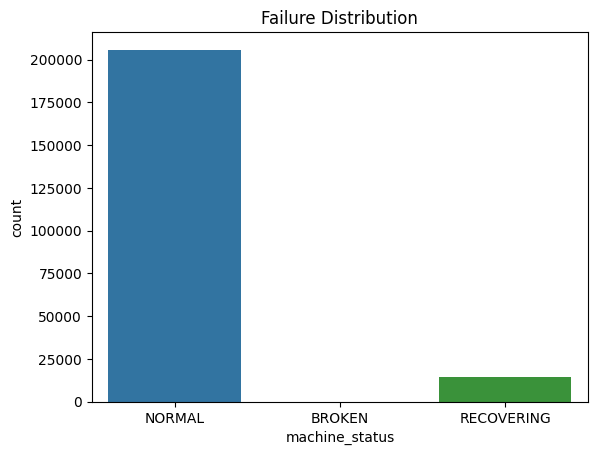

In [6]:
sns.countplot(x='machine_status', data=df)
print(df['machine_status_code'].value_counts())
plt.title("Failure Distribution")
plt.show()

### Correlation assessment
Assess the correlations of the sensors in relation to the fault status to predict machine break and malfunctions. The output is the source to narrow the dataset for the sensor data with relevance to the fault.

Considering the high inbalance of the data, the "recovery" type content shall be remained and mostly evaluated as fault (Not normal) status

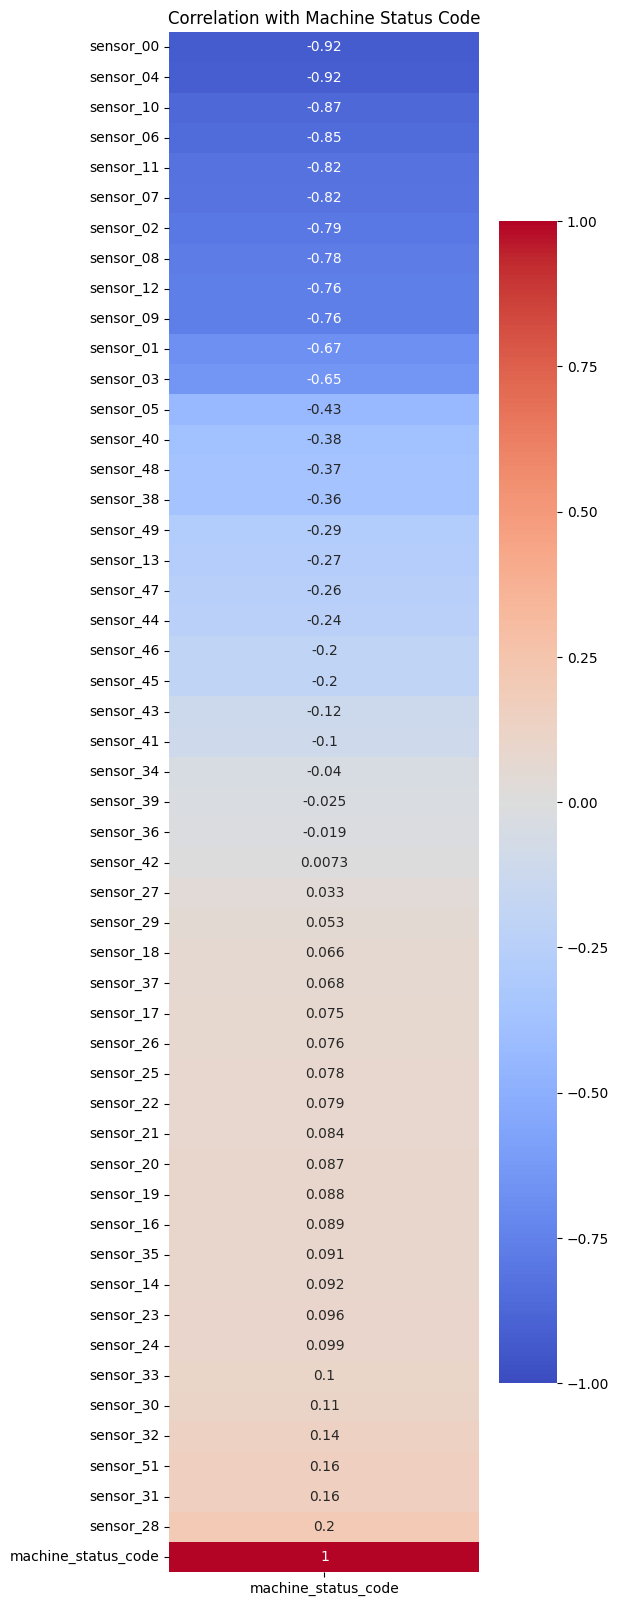

In [7]:
# correlation matrix
corr = df[metric_columns + ['machine_status_code']].corr()

#scoping the fault column
corr_machine_status = corr[['machine_status_code']]
corr_machine_status_sorted = corr_machine_status.sort_values(by='machine_status_code', ascending=True)

fig1, ax = plt.subplots(figsize=(5, 20))
sns.heatmap(corr_machine_status_sorted, annot=True, cmap='coolwarm', ax=ax, vmin=-1, vmax=1)
plt.title('Correlation with Machine Status Code')
plt.show()

In [8]:
df_clean = df[
    [
        'timestamp',
        'hour',
        'day_of_week',
        'month',
        'sensor_00',
        'sensor_04',
        'sensor_10',
        'sensor_06',
        'sensor_11',
        'sensor_07',
        'sensor_02',
        'machine_status_code',
    ]
]

### Visualisation of the time series data in relation to fault

In [9]:
# create new metric columns for the clean dataset
metric_columns_clean = [
    'sensor_00',
    'sensor_04',
    'sensor_10',
    'sensor_06',
    'sensor_11',
    'sensor_07',
    'sensor_02',
]

In [10]:
# create a new dataframe for only the values with status != 0 to mark them in the chart
df_broken = df_clean[df_clean['machine_status_code'] == 1]
df_recovery = df_clean[df_clean['machine_status_code'] == 2]

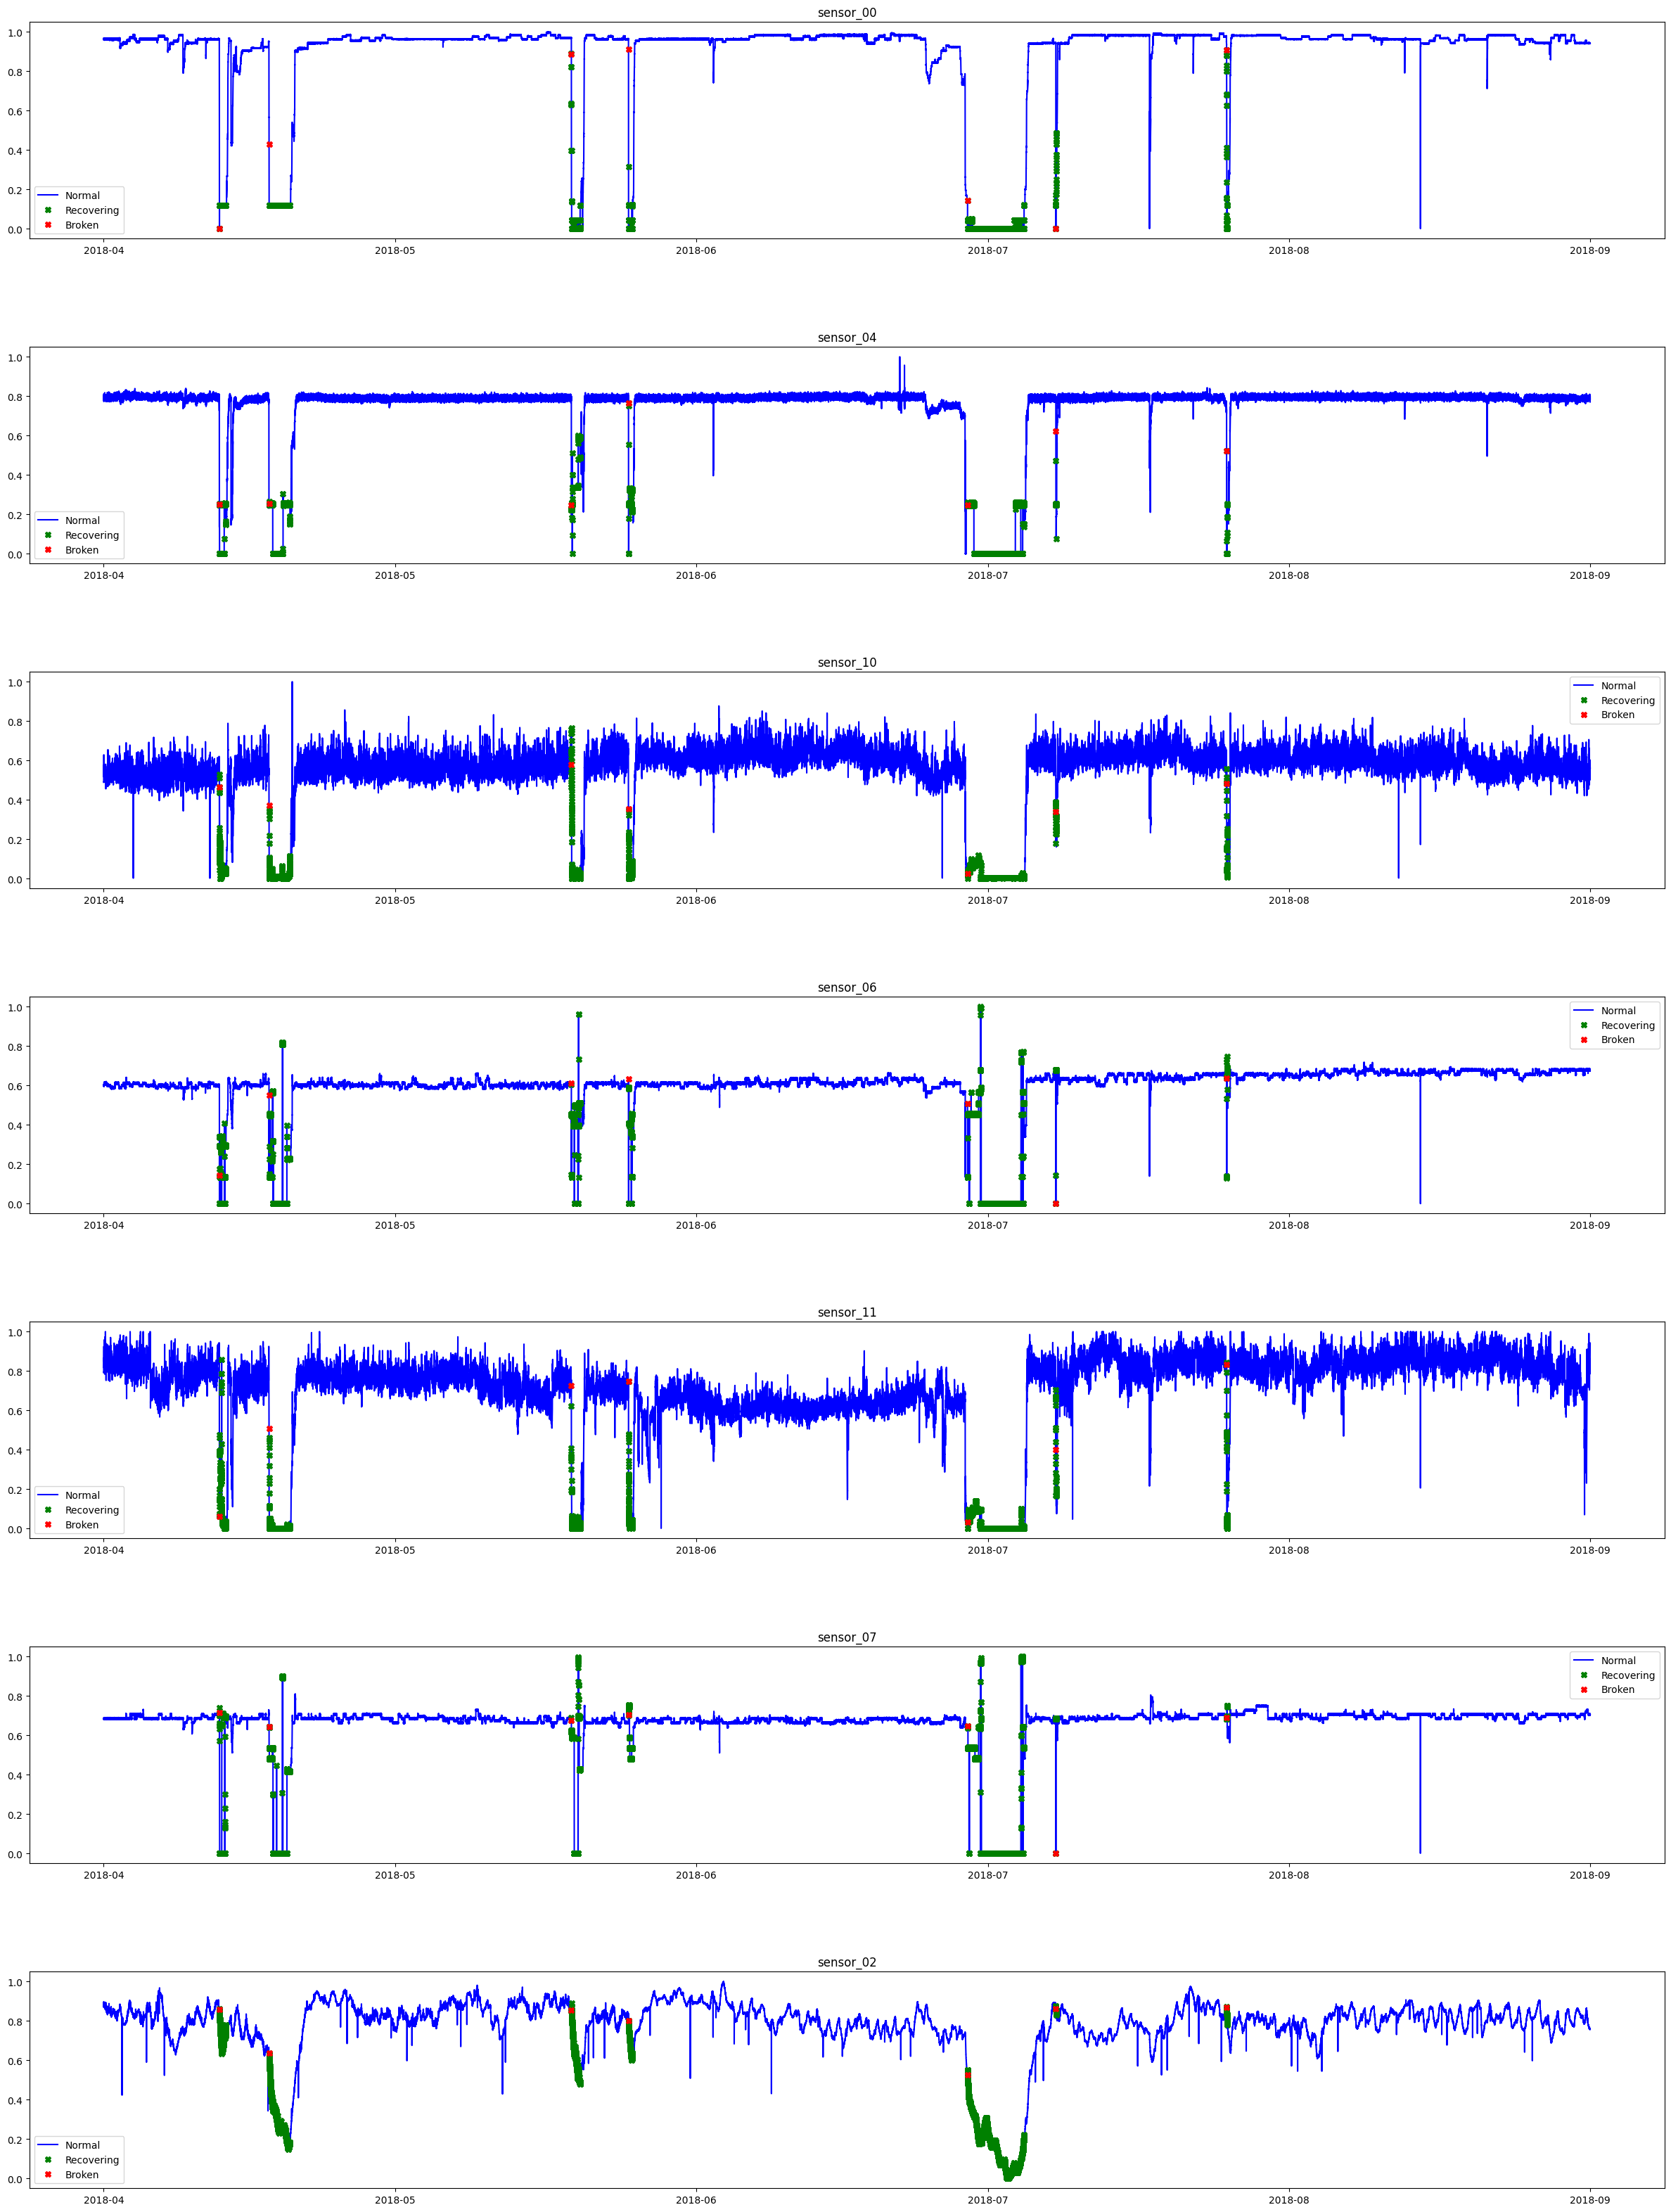

In [11]:
# check the distribution of erors in the timeline
time_series_error_by_sensor(df_clean,df_broken,df_recovery, metric_columns_clean)

In [12]:
# Drop the columns with high similarity values
df = df.drop(columns=['sensor_10','sensor_07'])

### Exporting the clean data for futher experiments and testing
Parquet export will be used for the clean data to keep the metadata for the column types

In [13]:
df_clean.to_parquet("data/clean/sensor_clean.pqt")